In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [8]:
import pandas as pd

df = pd.read_csv("spam.csv", sep=',' )

In [9]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [12]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [14]:
df_spam = df[df['Category'] == 'spam']
df_spam.shape

(747, 2)

In [15]:
df_ham = df[df['Category'] == 'ham']
df_ham.shape

(4825, 2)

In [17]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [19]:
df_balanced = pd.concat([df_spam, df_ham_downsampled])

In [21]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [22]:
df_balanced.head()

,Category,Message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


In [23]:
df_balanced.sample(5)

,Category,Message
4471,ham,"Lemme know when I can swing by and pick up, I'..."
2626,spam,"FREE RING TONE just text ""POLYS"" to 87131. The..."
3328,ham,what number do u live at? Is it 11?
1985,spam,Urgent! Please call 09061743810 from landline....
1663,spam,Hi if ur lookin 4 saucy daytime fun wiv busty ...


In [24]:
df_balanced['spam'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)

In [25]:
df_balanced.sample(5)
                   

,Category,Message,spam
328,ham,"I'd say that's a good sign but, well, you know...",0
3394,ham,Ok thanx...,0
4429,ham,Aiyar dun disturb u liao... Thk u have lots 2 ...,0
3905,spam,Your 2004 account for 07XXXXXXXXX shows 786 un...,1
1942,spam,WELL DONE! Your 4* Costa Del Sol Holiday or £5...,1


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify = df_balanced['spam'])


In [27]:
X_train.head()

146      Whats the staff name who is taking class for us?
1734    Hi, this is Mandy Sullivan calling from HOTMIX...
503                               Check with nuerologist.
2945    We currently have a message awaiting your coll...
2481    Urgent! call 09066612661 from landline. Your c...
Name: Message, dtype: object

In [29]:
bert_preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [33]:
import tensorflow_hub as hub
import tensorflow_text as text

In [34]:
bert_preprocess_layer = hub.KerasLayer(bert_preprocess_url)
bert_model_layer = hub.KerasLayer(bert_encoder_url)

In [35]:
def get_embeddings(sentences):
    preprocessed_sentences = bert_preprocess_layer(sentences)
    return bert_model_layer(preprocessed_sentences)['pooled_output']

In [36]:
get_embeddings(['this is good', 'this is bad'])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.883171  , -0.20125964,  0.44979206, ...,  0.28782353,
        -0.53117675,  0.8731352 ],
       [-0.91113317, -0.25871623,  0.1886178 , ...,  0.23924387,
        -0.59219915,  0.92819643]], dtype=float32)>

In [37]:
e = get_embeddings(['apple', 'banana', 'hand', 'leg', 'red', 'green'])

In [38]:
 e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.81964564, -0.29609615,  0.20951732, ...,  0.2559336 ,
        -0.58742994,  0.84345555],
       [-0.7606916 , -0.14219353,  0.49604708, ...,  0.42165393,
        -0.53221387,  0.80312145],
       [-0.78526646, -0.11334347,  0.6435041 , ...,  0.49873623,
        -0.5203378 ,  0.8504555 ],
       [-0.8601237 , -0.25382966,  0.50840086, ...,  0.3905872 ,
        -0.5704046 ,  0.87923956],
       [-0.8753112 , -0.34716713, -0.093082  , ...,  0.07180353,
        -0.67083716,  0.89402336],
       [-0.9323643 , -0.44057196, -0.7389972 , ..., -0.4006421 ,
        -0.7495927 ,  0.92926997]], dtype=float32)>

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

In [46]:
cosine_similarity([e[0]], [e[3]])

array([[0.9731548]], dtype=float32)

Lets build our model now !!


In [52]:
# Bert Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='Text Input Layer')
preprocessed_text =  bert_preprocess_layer(text_input)
outputs = bert_model_layer(preprocessed_text)

# Neural Network Layers
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation= 'sigmoid', name='output')(l)



#construct final model
model = tf.keras.Model(inputs =[text_input], outputs=[l])


In [53]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text Input Layer (InputLayer)  [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['Text Input Layer[0][0]']       
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [58]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
    tf.keras.metrics.Precision(name = "precision"),
    tf.keras.metrics.Recall(name = "recall")
]

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=METRICS)

In [59]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
35/35 [==============================] - 268s 7s/step - loss: 0.6606 - accuracy: 0.6348 - precision: 0.6466 - recall: 0.5946
Epoch 2/10
35/35 [==============================] - 258s 7s/step - loss: 0.5283 - accuracy: 0.7937 - precision: 0.7812 - recall: 0.8161
Epoch 3/10
35/35 [==============================] - 285s 8s/step - loss: 0.4455 - accuracy: 0.8714 - precision: 0.8549 - recall: 0.8946
Epoch 4/10
35/35 [==============================] - 277s 8s/step - loss: 0.3966 - accuracy: 0.8786 - precision: 0.8719 - recall: 0.8875
Epoch 5/10
35/35 [==============================] - 233s 7s/step - loss: 0.3652 - accuracy: 0.8929 - precision: 0.8846 - recall: 0.9036
Epoch 6/10
35/35 [==

In [60]:
model.evaluate(X_test, y_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
12/12 [==============================] - 71s 6s/step - loss: 0.2914 - accuracy: 0.9091 - precision: 0.9274 - recall: 0.8877


[0.29143714904785156,
 0.9090909361839294,
 0.9273743033409119,
 0.8877005577087402]

In [61]:
X_test.shape

(374,)

In [62]:
X_train.shape

(1120,)

In [63]:
y_predicted = model.predict(X_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [69]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)


In [72]:
y_predicted = y_predicted.flatten()

In [75]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)

In [76]:
cm

array([[174,  13],
       [ 21, 166]], dtype=int64)

Text(33.0, 0.5, 'Truth')

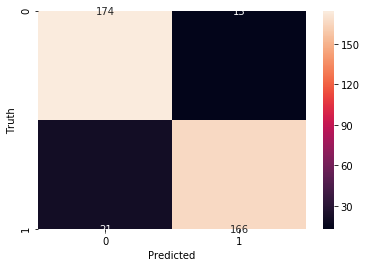

In [84]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Truth")


In [86]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       187
           1       0.93      0.89      0.91       187

   micro avg       0.91      0.91      0.91       374
   macro avg       0.91      0.91      0.91       374
weighted avg       0.91      0.91      0.91       374



In [89]:
model.predict(['you are awarded a lottery worth 2000 USD lucky draw', 'see you tomorrow'])

array([[0.16142505],
       [0.02247816]], dtype=float32)